# Calibrate cameras, create initial orthoimage and partial DSM

In [1]:
import os
from glob import glob
import subprocess
import numpy as np
from tqdm import tqdm
import shutil
import rasterio as rio
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import rioxarray as rxr
from shapely.geometry import Point
import geopandas as gpd
# Ignore warnings (rasterio throws a warning whenever an image is not georeferenced. Annoying in this case.)
import warnings
warnings.filterwarnings('ignore')

# Define input image files
data_folder = '/Users/rdcrlrka/Research/Soo_locks'
img_folder = os.path.join(data_folder, '20251001_imagery', 'frames_IR')
img_list = sorted(glob(os.path.join(img_folder, '*.tiff')))
print(f"{len(img_list)} images located")

# Grab standard input files
ref_dem_fn = os.path.join(os.getcwd(), 'inputs', '20251001_Soo_Model_1cm_UTM19N-fake.tif')
gcp_fn = os.path.join(os.getcwd(), 'inputs', 'GCP_lonlat-fake.gcp')
gcp_utm_fn = os.path.join(os.getcwd(), 'inputs', 'GCP_UTM19N-fake.txt')
cams_fn = os.path.join(os.getcwd(), 'inputs', 'cams_lonlat-fake.txt')

# Define output folders
out_folder = img_folder + '_proc_out'
os.makedirs(out_folder, exist_ok=True)
new_img_folder = os.path.join(out_folder, 'single_band_images')
undistorted_folder = os.path.join(out_folder, 'undistorted')
cam_folder = os.path.join(out_folder, 'cam_gen')
gcp_folder = os.path.join(out_folder, 'gcp')

init_stereo_folder = os.path.join(out_folder, 'init_stereo')
ba_folder = os.path.join(out_folder, 'bundle_adjust')
init_ortho_folder = os.path.join(out_folder, 'init_ortho')
final_stereo_folder = os.path.join(out_folder, 'final_stereo')
dem_align_folder = os.path.join(out_folder, 'align_dem')
cam_align_folder = os.path.join(out_folder, 'align_cams')
final_ortho_folder = os.path.join(out_folder, 'final_ortho')

16 images located


In [2]:
# # Resample the new DEM at each GCP
# import xarray as xr
# import geopandas as gpd
# from shapely.geometry import Point

# # Load GCP
# gcp = pd.read_csv(gcp_utm_fn, sep=' ')

# # Load DEM
# dem = rxr.open_rasterio(ref_dem_fn).squeeze()
# dem = xr.where(dem < -1e3, np.nan, dem)

# # Sample DEM at GCP points
# z_samp = [float(dem.sel(x=x, y=y, method='nearest').data)
#           for x,y in gcp[['X', 'Y']].values]
# gcp['Z'] = z_samp
# gcp.dropna(inplace=True)
# gcp[['pt_id', 'use_y', 'use_x', 'use_z', 'sample_row', 'sample_col']] = gcp[['pt_id', 'use_y', 'use_x', 'use_z', 'sample_row', 'sample_col']].astype(int)
# gcp_out_fn = os.path.join(os.path.dirname(gcp_utm_fn), 'GCP_UTM19N-fake.txt')
# gcp.to_csv(gcp_out_fn, sep=' ', index=False)

# # Reproject to WGS84
# gcp['geometry'] = [Point(x,y) for x,y in gcp[['X', 'Y']].values]
# gcp_gdf = gpd.GeoDataFrame(geometry=gcp['geometry'], crs="EPSG:32619")
# gcp_gdf.to_crs("EPSG:4326", inplace=True)

# gcp.drop(columns='geometry', inplace=True)
# gcp['X'] = [x.coords.xy[0][0] for x in gcp_gdf['geometry']]
# gcp['Y'] = [x.coords.xy[1][0] for x in gcp_gdf['geometry']]
# gcp

# gcp_out_fn = os.path.join(os.path.dirname(gcp_utm_fn), 'GCP_latlon-fake.txt')
# gcp.to_csv(gcp_out_fn, sep=' ', index=False)

## Convert images to single band in case they're RGB

A couple IR images (near the windows) were captured in RGB 

In [3]:
os.makedirs(new_img_folder, exist_ok=True)

# iterate over images
print('Saving single-band images to:', new_img_folder)
for img_fn in tqdm(img_list):
    # convert images to single band
    out_fn = os.path.join(new_img_folder, os.path.basename(img_fn))
    if os.path.exists(out_fn):
        continue
    cmd = [
        "gdal_translate",
        "-b", "1",
        img_fn, out_fn
    ]
    subprocess.run(cmd)

Saving single-band images to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/single_band_images


 56%|█████▋    | 9/16 [00:00<00:00, 62.05it/s]

Input file size is 4512, 2512
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 4512, 2512
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 4512, 2512
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 4512, 2512
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 4512, 2512
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 4512, 2512
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 4512, 2512
0...10...20...30...40...50...60.

100%|██████████| 16/16 [00:01<00:00, 15.73it/s]

..70...80...90...100 - done.
Input file size is 4512, 2512
0...10...20...30...40...50...60...70...80...90...100 - done.


## Undistort images using OpenCV and GCP

GROUP 1
Running calibration on 8 images...
RMS reprojection error: 444.98769316040125
K: [[1.42278435e+03 0.00000000e+00 1.92000000e+03]
 [0.00000000e+00 1.11042796e+03 1.08000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist: [-7.35715037e-02  9.64222522e-04  0.00000000e+00  0.00000000e+00
 -7.59925281e-07]


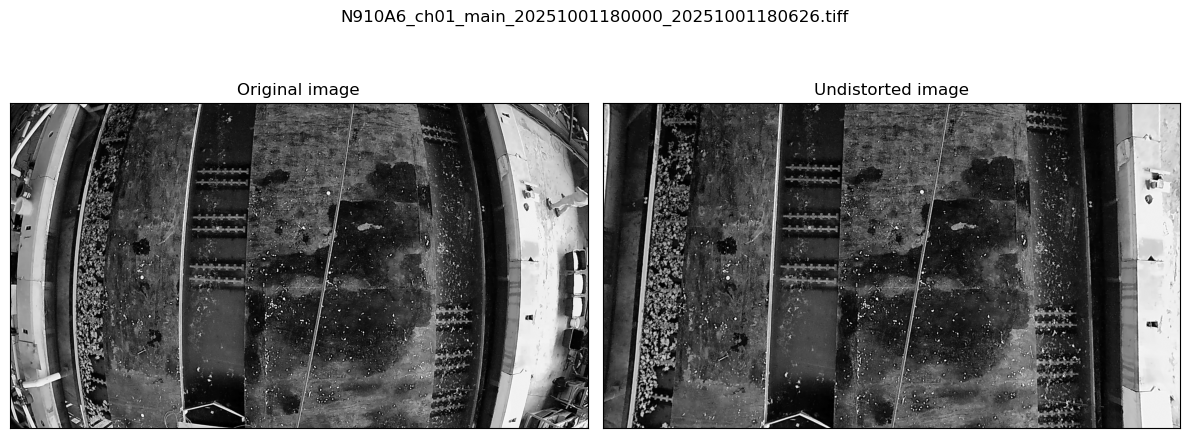

Undistorted image saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch01_main_20251001180000_20251001180626.tiff


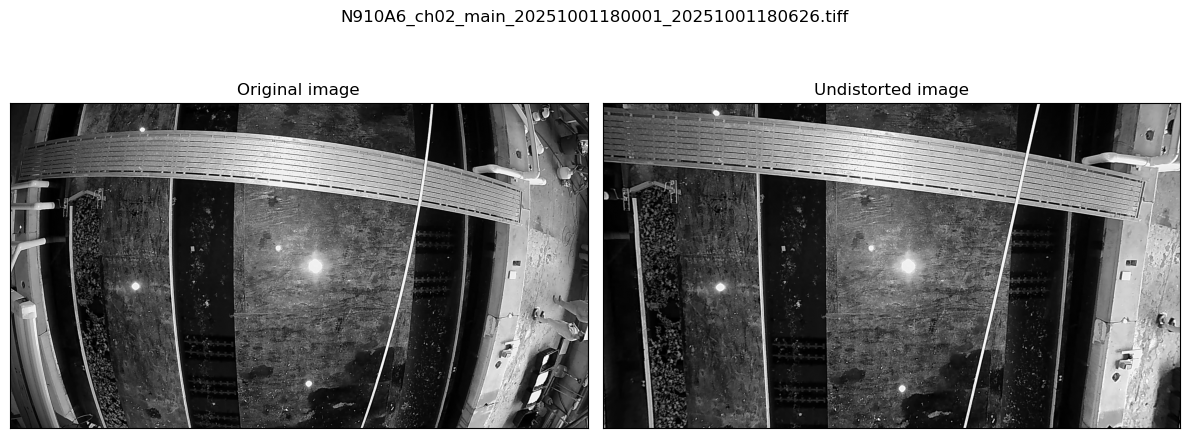

Undistorted image saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch02_main_20251001180001_20251001180626.tiff


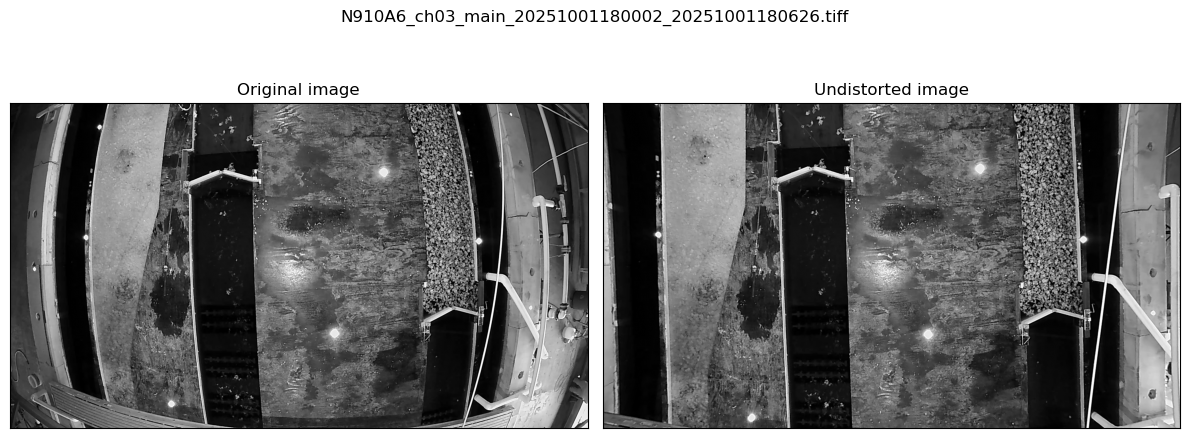

Undistorted image saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch03_main_20251001180002_20251001180626.tiff


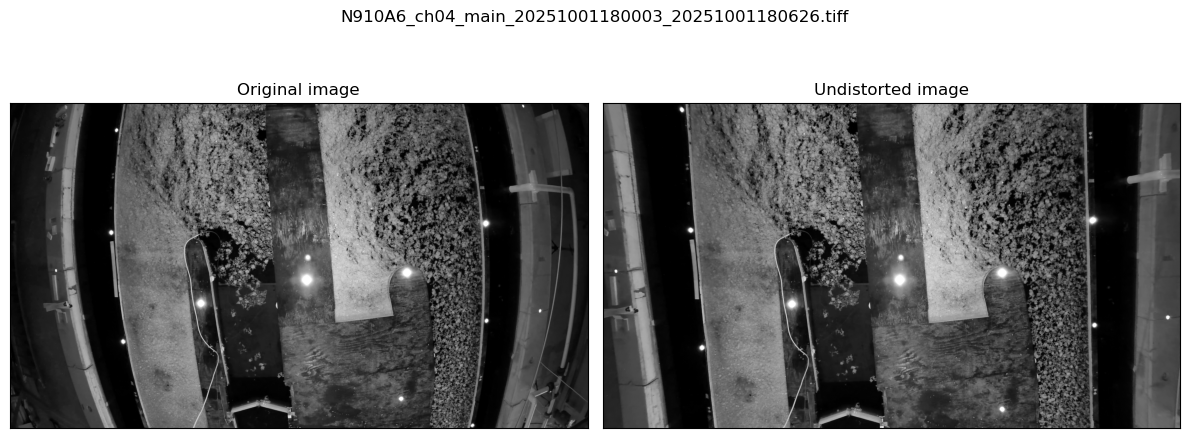

Undistorted image saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch04_main_20251001180003_20251001180626.tiff


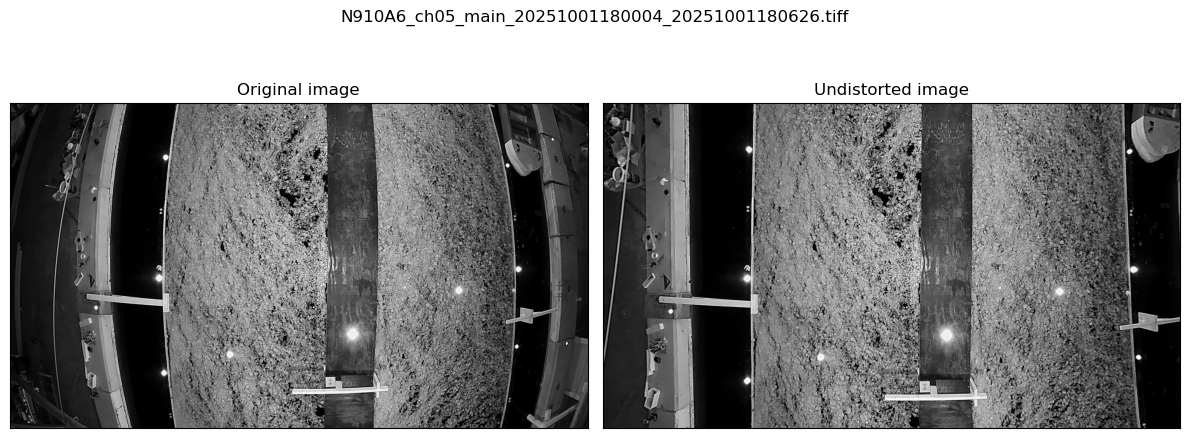

Undistorted image saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch05_main_20251001180004_20251001180626.tiff


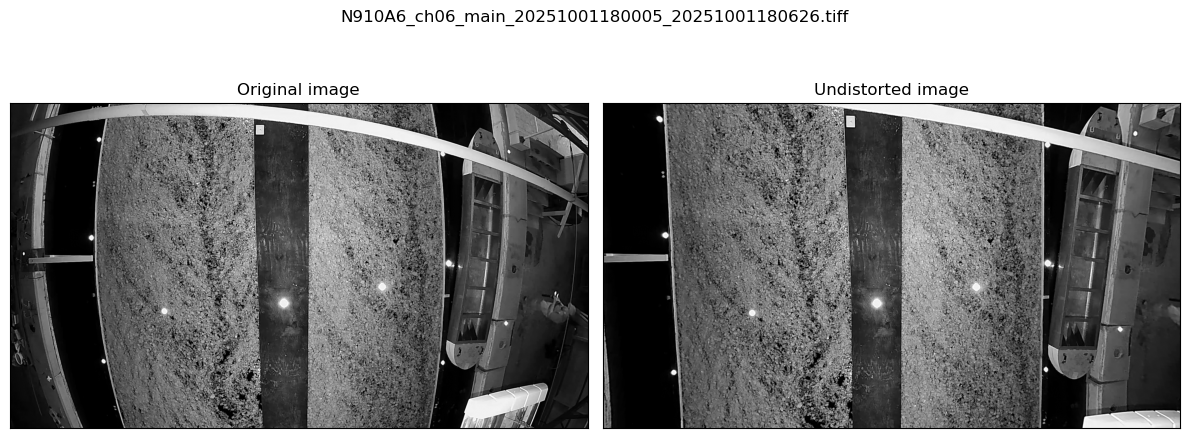

Undistorted image saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch06_main_20251001180005_20251001180626.tiff


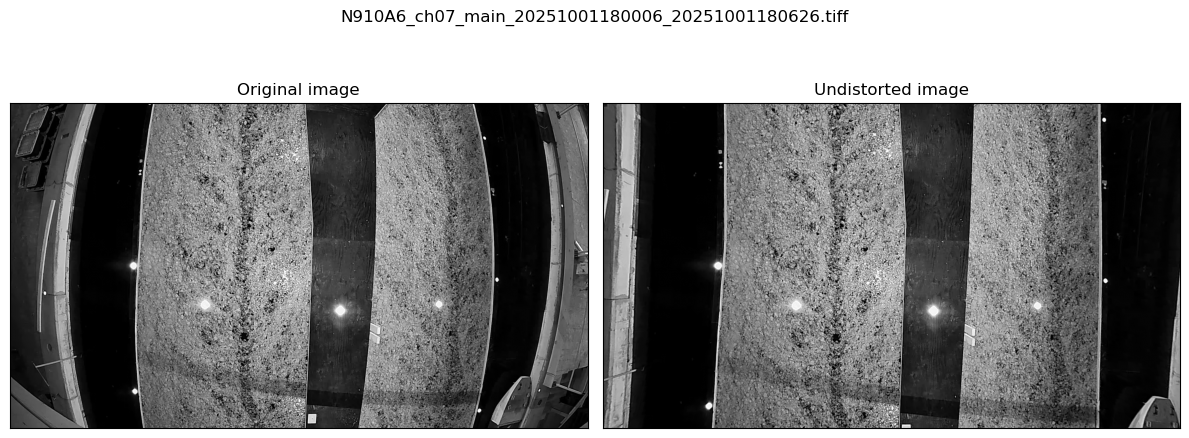

Undistorted image saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch07_main_20251001180006_20251001180626.tiff


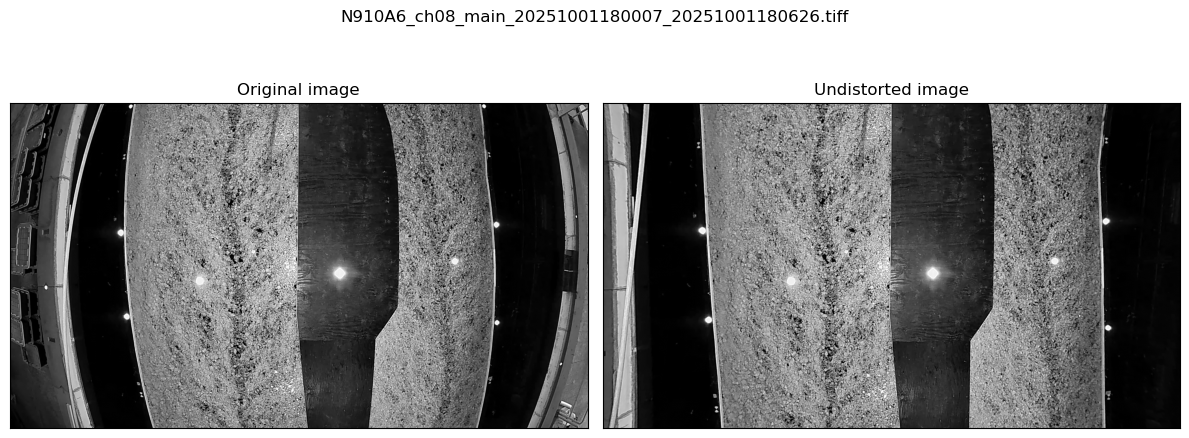

Undistorted image saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch08_main_20251001180007_20251001180626.tiff


In [93]:
def estimate_shared_intrinsics(image_files, gcp_files, output_folder, fx_mm=2.8, plot_results=True):
    """
    Solve for shared intrinsics across a list of images using OpenCV and given GCPs.
    """
    object_points_list = []
    image_points_list = []
    image_size = None

    # --- Build object/image point lists grouped by image ---
    for image_file in image_files:
        img_name = os.path.basename(image_file)

        # Load GCP
        gcp_file = [x for x in gcp_files if (os.path.splitext(img_name)[0] in x)][0]
        gcp = pd.read_csv(
            gcp_file, 
            sep=', ', 
            header=None,
            skiprows=[0],
            names=['pt_idx', 'Y', 'X', 'Z', 'Y_std', 'X_std', 'Z_std', 'img_path', 'sample_col', 'sample_row', 'use_Y', 'use_X', 'use_Z']
            )
        # reproject to UTM
        gcp['geometry']= [Point(x,y) for x,y in gcp[['X', 'Y']].values]
        gcp_gdf = gpd.GeoDataFrame(geometry=gcp['geometry'], crs="EPSG:4326")
        gcp_gdf.to_crs("EPSG:32619", inplace=True)
        gcp['X'] = [x.coords.xy[0][0] for x in gcp_gdf['geometry']]
        gcp['Y'] = [x.coords.xy[1][0] for x in gcp_gdf['geometry']]

        if len(gcp) == 0:
            print(f"No GCPs found for {img_name}, skipping.")
            continue

        if len(gcp) < 6:
            print(f"Skipping {img_name}: only {len(gcp)} points")
            continue

        object_points = gcp[["X","Y","Z"]].values.astype(np.float32).reshape(-1,1,3)
        # Subtract mean to center around origin
        object_points -= object_points.mean(axis=0)

        image_points = gcp[["sample_col","sample_row"]].values.astype(np.float32)
        image_points[:,0] -= 1  # account for zero-index isntead of 1 index when sampling
        image_points[:,1] -= 1

        img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        if image_size is None:
            h, w = img.shape[:2]
            image_size = (w,h)
        else:
            assert image_size == (w,h), "All images must have the same size"

        object_points_list.append(object_points)
        image_points_list.append(image_points)

    if len(object_points_list) < 1:
        raise ValueError("No valid GCPs matched to input images.")

    # --- Initial intrinsics ---
    fx = fy = 2000
    cx = image_size[0]/2
    cy = image_size[1]/2
    K_init = np.array([[fx,0,cx],[0,fy,cy],[0,0,1]], dtype=np.float64)
    dist_init = np.zeros(5)

    # --- Calibration flags ---
    flags = (
        cv2.CALIB_USE_INTRINSIC_GUESS | 
        cv2.CALIB_FIX_PRINCIPAL_POINT |
        cv2.CALIB_ZERO_TANGENT_DIST
    )

    print(f"Running calibration on {len(image_points_list)} images...")

    # --- Run calibration ---
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        object_points_list, image_points_list, image_size, K_init, dist_init, flags=flags
    )

    print("RMS reprojection error:", ret)
    print("K:", K)
    print("dist:", dist)

    # --- Undistort and visualize/save ---
    os.makedirs(output_folder, exist_ok=True)
    for image_file in image_files:
        img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        undistorted = cv2.undistort(img, K, dist)

        if plot_results:
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))
            ax[0].imshow(img, cmap='gray')
            ax[0].set_title('Original image')
            ax[1].imshow(undistorted, cmap='gray')
            ax[1].set_title('Undistorted image')
            for axis in ax:
                axis.set_xticks([])
                axis.set_yticks([])
            fig.suptitle(os.path.basename(image_file))
            fig.tight_layout()

            plt.show()

        # Save with (fake) georeferencing
        img_rxr = rxr.open_rasterio(image_file).squeeze()
        img_undistorted_rxr = img_rxr.copy()
        img_undistorted_rxr.data = undistorted
        # make sure attributes and CRS are set
        img_undistorted_rxr = img_undistorted_rxr.assign_attrs(img_rxr.attrs)
        img_undististorted_file = os.path.join(output_folder, os.path.basename(image_file))
        img_undistorted_rxr.rio.to_raster(img_undististorted_file)
        print('Undistorted image saved to file:', img_undististorted_file)

    return

os.makedirs(undistorted_folder, exist_ok=True)

image_list = sorted(glob(os.path.join(new_img_folder, '*.tiff')))
gcp_list = sorted(glob(os.path.join(gcp_folder, '*.gcp')))

# Do for each separate group separately
print('GROUP 1')
image_list_group1 = image_list[0:8]
estimate_shared_intrinsics(
    image_list_group1, 
    gcp_list, 
    undistorted_folder
    )

# print('GROUP 2')
# image_list_group2 = image_list[8:]
# estimate_shared_intrinsics(
#     image_list_group2,
#     gcp_utm_fn,
#     undistorted_folder
#    )
    

## Generate initial camera models

In [94]:
os.makedirs(cam_folder, exist_ok=True)

# Load "lat-lon" camera positions
cams = pd.read_csv(
    cams_fn,
    sep=' ',
    header=None,
    names=['img_name', 'lon', 'lat', 'Z', 'lon_std', 'lat_std']
    )

gcp_list = sorted(glob(os.path.join(gcp_folder, '*.gcp')))

# Estimate initial camera intrinsics in pixels
# focal length from camera docs
f_m = 2.8*1e-3
gsd_m = 2.5*1e-3
altitude_m = 4.3
# convert focal length from mm to pixels
# GSD = (Altidude * Pixel Pitch) / Focal Length
# --> Pixel Pitch = (GSD * Focal Length) / Altitude
px_pitch = (gsd_m * f_m) / altitude_m
# Convert focal length to pixels to use a pitch of 1
f_px = f_m / px_pitch
print('Focal length (pixels):', f_px)

# Small distortion initialization
distortion_values = [1e-6, 1e-6, 1e-6, 1e-6, 1e-6]

pbar = tqdm(total=len(cams))
for i, row in cams.iterrows():
    img_fn = os.path.join(undistorted_folder, row['img_name'])

    # Load GCP (lonlat-fake)
    gcp_file = [x for x in gcp_list if (os.path.splitext(row['img_name'])[0] in x)]
    if len(gcp_file) < 1:
        continue
    gcp = pd.read_csv(
        gcp_file[0], 
        sep=', ', 
        header=None,
        skiprows=[0],
        names=['pt_idx', 'Y', 'X', 'Z', 'Y_std', 'X_std', 'Z_std', 'img_path', 'sample_col', 'sample_row', 'use_Y', 'use_X', 'use_Z']
        )
    gcp['img_name'] = [os.path.basename(x) for x in gcp['img_path']]

    # Subset the GCP to image
    gcp_img = gcp.loc[gcp['img_name']==row['img_name']]
    # get "lat-lon" values and image pixel indices pairs
    lonlat_str = [(str(lon),str(lat)) for lon,lat in gcp_img[['X', 'Y']].values]
    lonlat_str = [' '.join(xy) for xy in lonlat_str]
    lonlat_str = ', '.join(lonlat_str)

    pxval_str = [(str(c),str(r)) for c,r in gcp_img[['sample_col', 'sample_row']].values]
    pxval_str = [' '.join(xy) for xy in pxval_str]
    pxval_str = ', '.join(pxval_str)

    # Image dimensions
    with rio.open(img_fn) as src:
        w_px = src.width
        h_px = src.height

    # Optical center
    cu = w_px / 2
    cv = h_px / 2

    # construct command
    cmd = [
        'cam_gen',
        # input image file
        img_fn,
        '--threads', '12',
        '--camera-type', 'pinhole',
        '--refine-camera',
        '--reference-dem', ref_dem_fn,
        # default height where DEM is NaN
        '--height-above-datum', str(float(np.round(gcp_img['Z'].mean()))),
        '--focal-length', str(f_px),
        '--pixel-pitch', '1',
        # horizontal, vertical components
        '--optical-center', str(int(cu)), str(int(cv)),
        # lon, lat, height
        '--camera-center-llh', str(row['lon']), str(row['lat']), str(row['Z']),
        '--lon-lat-values', lonlat_str,
        '--pixel-values', pxval_str,
        # output camera
        '-o', os.path.join(cam_folder, os.path.splitext(row['img_name'])[0] + '.tsai'),
    ]
    subprocess.run(cmd)
    pbar.update(1)

Focal length (pixels): 1720.0


 50%|█████     | 8/16 [14:45<14:45, 110.70s/it]


	--> Setting number of processing threads to: 12
Using datum: Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs
Using nodata value: -9999
Camera center (lon-lat-height) set on the command line: Vector3(-73.488768183874271,3.4031005725631767e-05,-3.863)
Could not determine a valid height value at lon-lat: -73.488768799391721 1.7025418876627476e-05. Will use a height of -7.
Could not determine a valid height value at lon-lat: -73.488772867467262 1.7522585428747559e-05. Will use a height of -7.
Could not determine a valid height value at lon-lat: -73.488776533743959 1.4986458526936172e-05. Will use a height of -7.
Could not determine a valid height value at lon-lat: -73.488800994888138 3.602419447914998e-05. Will use a height of -7.
Median pixel projection error in the coarse camera: 2227.4218006061619
Median pixel projection error in the refined camer

	--> Setting number of processing threads to: 12
Using datum: Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs
Using nodata value: -9999
Camera center (lon-lat-height) set on the command line: Vector3(-73.488777229775167,6.7430654324343009e-05,-3.778)
Could not determine a valid height value at lon-lat: -73.488801021441418 3.6001205640909489e-05. Will use a height of -8.
Median pixel projection error in the coarse camera: 445.236518482446
Median pixel projection error in the refined camera: 41.450050687215466
Output camera center lon, lat, and height above datum: Vector3(-73.488772213187659,6.8070315838634953e-05,-4.088814281170654)
Writing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/cam_gen/N910A6_ch02_main_20251001180001_20251001180626.tsai


	--> Setting number of processing threads to: 12
Using datum: Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs
Using nodata value: -9999
Camera center (lon-lat-height) set on the command line: Vector3(-73.488786104560191,9.7559876635296342e-05,-3.7120000000000002)
Could not determine a valid height value at lon-lat: -73.488760930836818 0.00010580906083869999. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488763848898842 0.00011503709711339999. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488766696509501 0.00012440037991890001. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488815683829614 9.2907471204402371e-05. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488819705121799 0.0001096529882778. Will use a hei

	--> Setting number of processing threads to: 12
Using datum: Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs
Using nodata value: -9999
Camera center (lon-lat-height) set on the command line: Vector3(-73.488795429984549,0.00013154758682599999,-3.6419999999999999)
Could not determine a valid height value at lon-lat: -73.488760940591973 0.0001057915329491. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488763823329833 0.0001150320765666. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488766673018389 0.0001243837768733. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488770861329755 0.0001380305580696. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488819729258182 0.000109727239573. Will use a height of -6.
Could 

	--> Setting number of processing threads to: 12
Using datum: Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs
Using nodata value: -9999
Camera center (lon-lat-height) set on the command line: Vector3(-73.48880679806058,0.0001618328422275,-3.532)
Could not determine a valid height value at lon-lat: -73.48877663091848 0.00015716880839149999. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488779802768676 0.0001681716969674. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488783616885598 0.00018338154254590001. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488785894454907 0.00019363205317509999. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488785997671556 0.0001940031775397. Will use a height of -6.
Median pixel

	--> Setting number of processing threads to: 12
Using datum: Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs
Using nodata value: -9999
Camera center (lon-lat-height) set on the command line: Vector3(-73.488813745770074,0.0001955598913277,-3.5169999999999999)
Could not determine a valid height value at lon-lat: -73.488787289684225 0.00019843817312719999. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488786028511839 0.00019393209710320001. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488785917858522 0.00019364561746370001. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488783617585497 0.00018336137226299999. Will use a height of -6.
Could not determine a valid height value at lon-lat: -73.488837062720194 0.00018303550741139999. Will use a hei

	--> Setting number of processing threads to: 12
Using datum: Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs
Using nodata value: -9999
Camera center (lon-lat-height) set on the command line: Vector3(-73.488826378858988,0.00022696715478899999,-3.742)
Could not determine a valid height value at lon-lat: -73.488796304444108 0.00023464473026720001. Will use a height of -7.
Could not determine a valid height value at lon-lat: -73.488799720634347 0.00024781061665329998. Will use a height of -7.
Could not determine a valid height value at lon-lat: -73.488801872196177 0.00025638835871380001. Will use a height of -7.
Median pixel projection error in the coarse camera: 793.47597570739322
Median pixel projection error in the refined camera: 67.898078790465888
Output camera center lon, lat, and height above datum: Vector3(-73.48883193070192,0.000221116203215

	--> Setting number of processing threads to: 12
Using datum: Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs
Using nodata value: -9999
Camera center (lon-lat-height) set on the command line: Vector3(-73.488832690481587,0.0002578215317394,-3.7930000000000001)
Could not determine a valid height value at lon-lat: -73.488801946475334 0.00025636178059740001. Will use a height of -7.
Could not determine a valid height value at lon-lat: -73.48880552767271 0.000270178356494. Will use a height of -7.
Could not determine a valid height value at lon-lat: -73.488799754383692 0.00024781303883730001. Will use a height of -7.
Median pixel projection error in the coarse camera: 403.76463954248408
Median pixel projection error in the refined camera: 75.351573557684958
Output camera center lon, lat, and height above datum: Vector3(-73.488845307725995,0.00025843819

In [95]:
# # Add initial distortion coefficients
# cam_list = sorted(glob(os.path.join(cam_folder, '*.tsai')))

# for cam in tqdm(cam_list):
#     with open(cam, 'r') as f:
#         cam_lines = f.read().split('\n')
#     # remove empty lines
#     cam_lines = [x for x in cam_lines if x!='']

#     # replace the NULL with TSAI
#     for i, line in enumerate(cam_lines):
#         if 'NULL' in line:
#             cam_lines[i] = 'TSAI'

#     # add distortion coefficients
#     cam_lines += [
#         'k1 = -1e-6',
#         'k2 = 1e-6',
#         'p1 = 0',
#         'p2 = 0',
#         'k3 = 1e-6'
#     ]

#     cam_lines_string = '\n'.join(cam_lines) + '\n'
    
#     # write to file
#     with open(cam, 'w') as f:
#         f.write(cam_lines_string)

## Run stereo correlation for dense matches

In [97]:
os.makedirs(init_stereo_folder, exist_ok=True)

img_list = sorted(glob(os.path.join(undistorted_folder, '*.tiff')))
cam_list = [glob(os.path.join(cam_folder, '*' + os.path.splitext(os.path.basename(x))[0]) + '*.tsai')[0]
            for x in img_list]

img_pairs = list(zip(img_list[0:-1], img_list[1:]))
cam_pairs = list(zip(cam_list[0:-1], cam_list[1:]))

for i in tqdm(range(0,len(img_pairs))):
    img1, img2 = img_pairs[i]
    cam1, cam2 = cam_pairs[i]

    pair_prefix = os.path.join(
        init_stereo_folder,
        os.path.splitext(os.path.basename(img1))[0] + '__' + os.path.splitext(os.path.basename(img2))[0],
        'run'
        )

    cmd = [
        'parallel_stereo',
        '--threads-singleprocess', '12',
        '--threads-multiprocess', '12',
        '--stop-point', '1', # stop after feature detection and matching
        img1, img2,
        cam1, cam2,
        pair_prefix
    ]
    subprocess.run(cmd)

  0%|          | 0/7 [00:00<?, ?it/s]

Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2025-Oct-08 15:59:57 ]: Stage 0 --> PREPROCESSING
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_stereo/N910A6_ch01_main_20251001180000_20251001180626__N910A6_ch02_main_20251001180001_20251001180626/run-log-stereo_pprc-10-08-1559-48508.txt
Using session: pinhole
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch01_main_20251001180000_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/cam_gen/N910A6_ch01_main_20251001180000_20251001180626.tsai
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch02_main_20251001180001_2

 14%|█▍        | 1/7 [00:09<00:55,  9.31s/it]

Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2025-Oct-08 16:00:07 ]: Stage 0 --> PREPROCESSING
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_stereo/N910A6_ch02_main_20251001180001_20251001180626__N910A6_ch03_main_20251001180002_20251001180626/run-log-stereo_pprc-10-08-1600-48591.txt
Using session: pinhole
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch02_main_20251001180001_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/cam_gen/N910A6_ch02_main_20251001180001_20251001180626.tsai
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch03_main_20251001180002_2

Traceback (most recent call last):
  File "/Users/rdcrlrka/Research/SkySat-Stereo/StereoPipeline-3.6.0-alpha-2025-09-11-arm64-OSX/libexec/parallel_stereo", line 1174, in <module>
    normal_run('stereo_pprc', opt, args, msg='%d: Preprocessing' % step)
  File "/Users/rdcrlrka/Research/SkySat-Stereo/StereoPipeline-3.6.0-alpha-2025-09-11-arm64-OSX/libexec/parallel_stereo", line 699, in normal_run
    raise Exception('Stereo step ' + kw['msg'] + ' failed')
Exception: Stereo step 0: Preprocessing failed
 29%|██▊       | 2/7 [00:16<00:39,  7.99s/it]

           Matching: [****************************************************] 100%
Elapsed time in ip matching: 0.429279 s.
	    Matched points: 230
	    Filtering interest point matches using homography.
	    Homography ip filter inlier threshold: 200
	    RANSAC iterations:                     1000
RANSAC was unable to find a fit that matched the supplied data.
Attempting RANSAC with 76 inliers.
RANSAC was unable to find a fit that matched the supplied data.
Attempting RANSAC with 50 inliers.
RANSAC was unable to find a fit that matched the supplied data.
Attempting RANSAC with 33 inliers.
RANSAC was unable to find a fit that matched the supplied data.
Attempting RANSAC with 22 inliers.
RANSAC was unable to find a fit that matched the supplied data.
Attempting RANSAC with 14 inliers.
Homography matrix:
Matrix3x3((-0.119191,0.465329,603.002)(-0.469517,1.07409,1062.18)(-0.000313766,0.000327423,1))
Number of inliers: 14.
Filtering time: 0.022458 seconds.
	    * Writing match file: /Users/

 43%|████▎     | 3/7 [00:25<00:33,  8.37s/it]

Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2025-Oct-08 16:00:23 ]: Stage 0 --> PREPROCESSING
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_stereo/N910A6_ch04_main_20251001180003_20251001180626__N910A6_ch05_main_20251001180004_20251001180626/run-log-stereo_pprc-10-08-1600-48735.txt
Using session: pinhole
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch04_main_20251001180003_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/cam_gen/N910A6_ch04_main_20251001180003_20251001180626.tsai
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch05_main_20251001180004_2

 57%|█████▋    | 4/7 [00:34<00:26,  8.82s/it]

Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2025-Oct-08 16:00:32 ]: Stage 0 --> PREPROCESSING
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_stereo/N910A6_ch05_main_20251001180004_20251001180626__N910A6_ch06_main_20251001180005_20251001180626/run-log-stereo_pprc-10-08-1600-48807.txt
Using session: pinhole
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch05_main_20251001180004_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/cam_gen/N910A6_ch05_main_20251001180004_20251001180626.tsai
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch06_main_20251001180005_2

 71%|███████▏  | 5/7 [00:43<00:17,  8.90s/it]

Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2025-Oct-08 16:00:41 ]: Stage 0 --> PREPROCESSING
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_stereo/N910A6_ch06_main_20251001180005_20251001180626__N910A6_ch07_main_20251001180006_20251001180626/run-log-stereo_pprc-10-08-1600-48881.txt
Using session: pinhole
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch06_main_20251001180005_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/cam_gen/N910A6_ch06_main_20251001180005_20251001180626.tsai
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch07_main_20251001180006_2

 86%|████████▌ | 6/7 [00:52<00:08,  8.85s/it]

Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2025-Oct-08 16:00:50 ]: Stage 0 --> PREPROCESSING
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_stereo/N910A6_ch07_main_20251001180006_20251001180626__N910A6_ch08_main_20251001180007_20251001180626/run-log-stereo_pprc-10-08-1600-48952.txt
Using session: pinhole
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch07_main_20251001180006_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/cam_gen/N910A6_ch07_main_20251001180006_20251001180626.tsai
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch08_main_20251001180007_2

100%|██████████| 7/7 [01:01<00:00,  8.83s/it]


## Bundle adjust using dense matches

In [99]:
os.makedirs(ba_folder, exist_ok=True)

cam_list = sorted(glob(os.path.join(cam_folder, '*.tsai')))
img_list = [os.path.join(new_img_folder, os.path.basename(x).replace('.tsai','.tiff')) 
            for x in cam_list]

# copy dense matches from stereo to bundle_adjust folder
match_list = glob(os.path.join(init_stereo_folder, '*', '*.match'))
print(f'Copying {len(match_list)} matches from stereo to the bundle adjust folder')
for match in tqdm(match_list):
    match_out = os.path.join(ba_folder, os.path.basename(match))
    _ = shutil.copy2(match, match_out)

cmd = [
    'parallel_bundle_adjust',
    '-t', 'pinhole',
    '--threads', '12',
    '--num-iterations', '2000',
    '--num-passes', '2',
    # create new camera files
    '--inline-adjustments',
    # more confident in the camera positions
    # '--camera-position-weight', '5',
    # use the matches from stereo
    '--force-reuse-match-files',
    # solve intrinsics
    # '--solve-intrinsics',
    # '--intrinsics-to-share', 'none',
    # '--intrinsics-to-float', 'all',
    '--heights-from-dem', ref_dem_fn,
    '--heights-from-dem-uncertainty', '0.02',
    '--remove-outliers-params', "75.0 3.0 20 25",
    '-o', os.path.join(ba_folder, 'run'),
] + img_list + cam_list
subprocess.run(cmd)



Copying 7 matches from stereo to the bundle adjust folder


100%|██████████| 7/7 [00:00<00:00, 1253.74it/s]


Using 12 threads and 3 processes.
	--> Setting number of processing threads to: 12
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run-log-bundle_adjust-10-08-1603-49711.txt
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/single_band_images/N910A6_ch01_main_20251001180000_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/cam_gen/N910A6_ch01_main_20251001180000_20251001180626.tsai
Guessed the datum from camera position.
Datum:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs
Loading the cameras.
Using session: pinhole
Loading cameras elapsed time: 0.000682 seconds.
Computing statistics for /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/single_band_images/N910A6_ch01_main_20251001180000_202510

CompletedProcess(args=['parallel_bundle_adjust', '-t', 'pinhole', '--threads', '12', '--num-iterations', '2000', '--num-passes', '2', '--inline-adjustments', '--force-reuse-match-files', '--heights-from-dem', '/Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif', '--heights-from-dem-uncertainty', '0.02', '--remove-outliers-params', '75.0 3.0 20 25', '-o', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/single_band_images/N910A6_ch01_main_20251001180000_20251001180626.tiff', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/single_band_images/N910A6_ch02_main_20251001180001_20251001180626.tiff', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/single_band_images/N910A6_ch03_main_20251001180002_20251001180626.tiff', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_pro

## Initial orthorectification

In [5]:
os.makedirs(init_ortho_folder, exist_ok=True)

img_list = sorted(glob(os.path.join(undistorted_folder, '*.tiff')))
cam_list = sorted(glob(os.path.join(ba_folder, '*.tsai')))

for img, cam in tqdm(list(zip(img_list, cam_list))):
    img_out_fn = os.path.join(init_ortho_folder, os.path.splitext(os.path.basename(img))[0] + '_map.tiff')
    cmd = [
        'mapproject',
        '--tr', '0.005',
        '--threads', '12',
        ref_dem_fn, img, cam, img_out_fn
    ]
    subprocess.run(cmd)


  0%|          | 0/8 [00:00<?, ?it/s]

mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch01_main_20251001180000_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run-N910A6_ch01_main_20251001180000_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch01_main_20251001180000_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of processing threads to: 12
Using session: pinhole
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch01_main_20251001180000_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run-N910A6_ch01_main_20251001180000_20251001180626.tsai
Output pixel size: 0.0050000000000000001
Projected spa

 12%|█▎        | 1/8 [00:14<01:40, 14.31s/it]

Input file size is 1531, 1193
0...10...20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch01_main_20251001180000_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch01_main_20251001180000_20251001180626_map.tiff
Finished in 8.675855875015259 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch02_main_20251001180001_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run-N910A6_ch02_main_20251001180001_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch02_main_20251001180001_20251001180626_map.tiff --tr 0.005 --threa

 25%|██▌       | 2/8 [00:25<01:16, 12.73s/it]

...10...20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch02_main_20251001180001_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch02_main_20251001180001_20251001180626_map.tiff
Finished in 8.803369045257568 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch03_main_20251001180002_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run-N910A6_ch03_main_20251001180002_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch03_main_20251001180002_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of pr

 38%|███▊      | 3/8 [00:37<01:01, 12.33s/it]

...10...20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch03_main_20251001180002_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch03_main_20251001180002_20251001180626_map.tiff
Finished in 9.012406587600708 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch04_main_20251001180003_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run-N910A6_ch04_main_20251001180003_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch04_main_20251001180003_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of pr

 50%|█████     | 4/8 [00:49<00:48, 12.09s/it]

..20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch04_main_20251001180003_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch04_main_20251001180003_20251001180626_map.tiff
Finished in 8.911417245864868 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch05_main_20251001180004_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run-N910A6_ch05_main_20251001180004_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch05_main_20251001180004_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of processi

 62%|██████▎   | 5/8 [01:07<00:42, 14.26s/it]

..80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch05_main_20251001180004_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch05_main_20251001180004_20251001180626_map.tiff
Finished in 15.29645299911499 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch06_main_20251001180005_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run-N910A6_ch06_main_20251001180005_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch06_main_20251001180005_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of processing threads to: 12
Using sessio

 75%|███████▌  | 6/8 [01:19<00:26, 13.34s/it]

..20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch06_main_20251001180005_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch06_main_20251001180005_20251001180626_map.tiff
Finished in 8.738240957260132 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch07_main_20251001180006_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run-N910A6_ch07_main_20251001180006_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch07_main_20251001180006_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of processi

 88%|████████▊ | 7/8 [01:30<00:12, 12.71s/it]

.20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch07_main_20251001180006_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch07_main_20251001180006_20251001180626_map.tiff
Finished in 8.59779667854309 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch08_main_20251001180007_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run-N910A6_ch08_main_20251001180007_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch08_main_20251001180007_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of processing

100%|██████████| 8/8 [01:41<00:00, 12.74s/it]

.20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch08_main_20251001180007_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/init_ortho/N910A6_ch08_main_20251001180007_20251001180626_map.tiff
Finished in 8.544517755508423 seconds.


## Final stereo

In [9]:
os.makedirs(final_stereo_folder, exist_ok=True)

img_list = sorted(glob(os.path.join(init_ortho_folder, '*.tiff')))
cam_list = [glob(os.path.join(ba_folder, '*' + os.path.splitext(os.path.basename(x))[0].replace('_map','')) + '*.tsai')[0]
            for x in img_list]

img_pairs = list(zip(img_list[0:-1], img_list[1:]))
cam_pairs = list(zip(cam_list[0:-1], cam_list[1:]))

for i in tqdm(range(0,len(img_pairs))):
    img1, img2 = img_pairs[i]
    cam1, cam2 = cam_pairs[i]

    pair_prefix = os.path.join(
        final_stereo_folder,
        os.path.splitext(os.path.basename(img1))[0] + '__' + os.path.splitext(os.path.basename(img2))[0],
        'run'
        )

    cmd = [
        'parallel_stereo',
        '--threads-singleprocess', '12',
        '--threads-multiprocess', '12',
        img1, img2,
        cam1, cam2,
        pair_prefix,
        ref_dem_fn
    ]
    subprocess.run(cmd)

  0%|          | 0/7 [00:00<?, ?it/s]

Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2025-Oct-08 20:22:16 ]: Stage 0 --> PREPROCESSING
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch01_main_20251001180000_20251001180626_map__N910A6_ch02_main_20251001180001_20251001180626_map/run-log-stereo_pprc-10-08-2022-3598.txt
Using session: pinholemappinhole
Images before mapprojection: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch01_main_20251001180000_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch02_main_20251001180001_20251001180626.tiff
Mapprojection cameras: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/r

 14%|█▍        | 1/7 [01:11<07:06, 71.14s/it]

Input file size is 1531, 1193
0...10...20...30...40...50...60...70...80...90...100 - done.
Renaming: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch01_main_20251001180000_20251001180626_map__N910A6_ch02_main_20251001180001_20251001180626_map/run-RD_merged.tif to /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch01_main_20251001180000_20251001180626_map__N910A6_ch02_main_20251001180001_20251001180626_map/run-RD.tif
Keeping: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch01_main_20251001180000_20251001180626_map__N910A6_ch02_main_20251001180001_20251001180626_map/run-L_sub.tif
Keeping: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch01_main_20251001180000_20251001180626_map__N910A6_ch02_main_20251001180001_20251001180626_map/run-L.vwip
Deleting: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc

 29%|██▊       | 2/7 [02:17<05:40, 68.19s/it]

Input file size is 1527, 1404
0...10...20...30...40...50...60...70...80...90...100 - done.
Renaming: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch02_main_20251001180001_20251001180626_map__N910A6_ch03_main_20251001180002_20251001180626_map/run-PC_merged.tif to /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch02_main_20251001180001_20251001180626_map__N910A6_ch03_main_20251001180002_20251001180626_map/run-PC.tif
Keeping: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch02_main_20251001180001_20251001180626_map__N910A6_ch03_main_20251001180002_20251001180626_map/run-F.tif
Deleting: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch02_main_20251001180001_20251001180626_map__N910A6_ch03_main_20251001180002_20251001180626_map/run-0_0_1527_1404
Output point cloud: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/

 43%|████▎     | 3/7 [03:26<04:34, 68.73s/it]

Input file size is 1599, 1746
0...10...20...30...40...50...60...70...80...90...100 - done.
Renaming: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch03_main_20251001180002_20251001180626_map__N910A6_ch04_main_20251001180003_20251001180626_map/run-PC_merged.tif to /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch03_main_20251001180002_20251001180626_map__N910A6_ch04_main_20251001180003_20251001180626_map/run-PC.tif
Keeping: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch03_main_20251001180002_20251001180626_map__N910A6_ch04_main_20251001180003_20251001180626_map/run-lMask.tif
Keeping: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch03_main_20251001180002_20251001180626_map__N910A6_ch04_main_20251001180003_20251001180626_map/run-F.tif
Keeping: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_o

Traceback (most recent call last):
  File "/Users/rdcrlrka/Research/SkySat-Stereo/StereoPipeline-3.6.0-alpha-2025-09-11-arm64-OSX/libexec/parallel_stereo", line 1174, in <module>
    normal_run('stereo_pprc', opt, args, msg='%d: Preprocessing' % step)
  File "/Users/rdcrlrka/Research/SkySat-Stereo/StereoPipeline-3.6.0-alpha-2025-09-11-arm64-OSX/libexec/parallel_stereo", line 699, in normal_run
    raise Exception('Stereo step ' + kw['msg'] + ' failed')
Exception: Stereo step 0: Preprocessing failed
 57%|█████▋    | 4/7 [03:33<02:13, 44.49s/it]

Detect interest points: [*************************************************] 100%
	    Removing IP near nodata with radius 4
	    Building descriptors
	    Number of interest points: 0
	    Writing interest points: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch04_main_20251001180003_20251001180626_map__N910A6_ch05_main_20251001180004_20251001180626_map/run-R.vwip
Elapsed time in ip detection: 0.418582 s.
	--> Uniqueness threshold: 0.8
           Matching: [****************************************************]
Elapsed time in ip matching: 1.1e-05 s.
	    Matched points: 0


ERROR: Could not find interest points.



Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2025-Oct-08 20:25:50 ]: Stage 0 --> PREPROCESSING
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log: 

Traceback (most recent call last):
  File "/Users/rdcrlrka/Research/SkySat-Stereo/StereoPipeline-3.6.0-alpha-2025-09-11-arm64-OSX/libexec/parallel_stereo", line 1185, in <module>
    calc_lowres_disp(args, opt, sep, resume = opt.resume_at_corr)
  File "/Users/rdcrlrka/Research/SkySat-Stereo/StereoPipeline-3.6.0-alpha-2025-09-11-arm64-OSX/libexec/asp_stereo_utils.py", line 264, in calc_lowres_disp
    stereo_run('stereo_corr', local_args, opt, msg='')
  File "/Users/rdcrlrka/Research/SkySat-Stereo/StereoPipeline-3.6.0-alpha-2025-09-11-arm64-OSX/libexec/asp_stereo_utils.py", line 188, in stereo_run
    raise Exception('Stereo step ' + kw['msg'] + ' failed')
Exception: Stereo step  failed
 71%|███████▏  | 5/7 [03:44<01:04, 32.29s/it]

	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch05_main_20251001180004_20251001180626_map__N910A6_ch06_main_20251001180005_20251001180626_map/run-log-stereo_corr-10-08-2025-4995.txt
Using session: pinholemappinhole
Images before mapprojection: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch05_main_20251001180004_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch06_main_20251001180005_20251001180626.tiff
Mapprojection cameras: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run-N910A6_ch05_main_20251001180004_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/bundle_adjust/run-N910A6_ch06_main_2025

 86%|████████▌ | 6/7 [04:44<00:41, 41.67s/it]

Input file size is 1485, 1596
0...10...20...30...40...50...60...70...80...90...100 - done.
Renaming: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch06_main_20251001180005_20251001180626_map__N910A6_ch07_main_20251001180006_20251001180626_map/run-PC_merged.tif to /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch06_main_20251001180005_20251001180626_map__N910A6_ch07_main_20251001180006_20251001180626_map/run-PC.tif
Keeping: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch06_main_20251001180005_20251001180626_map__N910A6_ch07_main_20251001180006_20251001180626_map/run-R.tif
Keeping: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch06_main_20251001180005_20251001180626_map__N910A6_ch07_main_20251001180006_20251001180626_map/run-F.tif
Keeping: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/f

100%|██████████| 7/7 [07:23<00:00, 63.30s/it]

Input file size is 1384, 1459
0...10...20...30...40...50...60...70...80...90...100 - done.
Renaming: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch07_main_20251001180006_20251001180626_map__N910A6_ch08_main_20251001180007_20251001180626_map/run-PC_merged.tif to /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch07_main_20251001180006_20251001180626_map__N910A6_ch08_main_20251001180007_20251001180626_map/run-PC.tif
Keeping: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch07_main_20251001180006_20251001180626_map__N910A6_ch08_main_20251001180007_20251001180626_map/run-PC_sub.tif
Keeping: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch07_main_20251001180006_20251001180626_map__N910A6_ch08_main_20251001180007_20251001180626_map/run-rMask.tif
Keeping: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_p

## Rasterize point clouds

In [10]:
# Rasterize the point clouds
pc_files = sorted(glob(os.path.join(final_stereo_folder, '*', '*-PC.tif')))
print('Rasterizing the point clouds...')
for pc in tqdm(pc_files):
    cmd = [
        'point2dem',
        '--threads', '12',
        '--tr', '0.01',
        pc
    ]
    subprocess.run(cmd)

Rasterizing the point clouds...


  0%|          | 0/5 [00:00<?, ?it/s]

	--> Setting number of processing threads to: 12
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch01_main_20251001180000_20251001180626_map__N910A6_ch02_main_20251001180001_20251001180626_map/run-log-point2dem-10-08-2130-7133.txt
Bounding box and triangulation error range estimation: [******************] 99%
Point cloud extent estimation: [******************************************] 60%
Collected a sample of 276911 positive triangulation errors.
Error percentiles: Q1 (25%): 0.0190086, Q2 (50%): 0.0483856, Q3 (75%): 0.146885.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 0.440655 meters.
	Starting DEM rasterization
	--> DEM spacing: 0.01 pt/px
	             or: 100 px/pt
Creating output file that is Vector2(656,404) px.
Writing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch01_main_20251001180000_20251001180626_map__N910A6_ch02_m

 20%|██        | 1/5 [00:01<00:07,  1.97s/it]

DEM: [********************************************************************]
Percentage of valid pixels: 24.445%
	--> Setting number of processing threads to: 12
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch02_main_20251001180001_20251001180626_map__N910A6_ch03_main_20251001180002_20251001180626_map/run-log-point2dem-10-08-2130-7174.txt
Bounding box and triangulation error range estimation: [******************] 99%
Point cloud extent estimation: [******************************************] 36%
Collected a sample of 45956 positive triangulation errors.
Error percentiles: Q1 (25%): 0.0549545, Q2 (50%): 0.18449, Q3 (75%): 0.341503.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 1.02451 meters.
	Starting DEM rasterization
	--> DEM spacing: 0.01 pt/px
	             or: 100 px/pt
Creating output file that is Vector2(639,312) px.
Writing: /Users/rdcrlrka/Research/Soo_locks/202510

 40%|████      | 2/5 [00:03<00:05,  1.83s/it]

DEM: [********************************************************************] 100%
Percentage of valid pixels: 11.1793%
	--> Setting number of processing threads to: 12
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch03_main_20251001180002_20251001180626_map__N910A6_ch04_main_20251001180003_20251001180626_map/run-log-point2dem-10-08-2130-7216.txt
Bounding box and triangulation error range estimation: [******************] 99%
Point cloud extent estimation: [*****.....................................] 14%

 60%|██████    | 3/5 [00:05<00:03,  1.83s/it]

Point cloud extent estimation: [******************************************] 33%
Collected a sample of 148141 positive triangulation errors.
Error percentiles: Q1 (25%): 0.701889, Q2 (50%): 0.757301, Q3 (75%): 0.785007.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 2.35502 meters.
	Starting DEM rasterization
	--> DEM spacing: 0.01 pt/px
	             or: 100 px/pt
Creating output file that is Vector2(478,151) px.
Writing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch03_main_20251001180002_20251001180626_map__N910A6_ch04_main_20251001180003_20251001180626_map/run-DEM.tif
DEM: [********************************************************************] 100%
Percentage of valid pixels: 36.6663%
	--> Setting number of processing threads to: 12
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch06_main_20251001180005_20251001180626_map__N910

 80%|████████  | 4/5 [00:07<00:01,  1.79s/it]

DEM: [********************************************************************] 100%
Percentage of valid pixels: 11.6832%
	--> Setting number of processing threads to: 12
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch07_main_20251001180006_20251001180626_map__N910A6_ch08_main_20251001180007_20251001180626_map/run-log-point2dem-10-08-2130-7292.txt
Bounding box and triangulation error range estimation: [******************] 99%
Point cloud extent estimation: [***********...............................] 28%

100%|██████████| 5/5 [00:09<00:00,  1.82s/it]

Point cloud extent estimation: [******************************************] 47%
Collected a sample of 167471 positive triangulation errors.
Error percentiles: Q1 (25%): 0.0784378, Q2 (50%): 0.124477, Q3 (75%): 0.146645.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 0.439934 meters.
	Starting DEM rasterization
	--> DEM spacing: 0.01 pt/px
	             or: 100 px/pt
Creating output file that is Vector2(557,361) px.
Writing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch07_main_20251001180006_20251001180626_map__N910A6_ch08_main_20251001180007_20251001180626_map/run-DEM.tif
DEM: [********************************************************************] 100%
Percentage of valid pixels: 20.155%


## Mosaic DEMs

In [11]:
dem_fns = sorted(glob(os.path.join(final_stereo_folder, '*', '*DEM.tif')))
print('Creating mosaics of DEM using blended, median, NMAD, and count operators')
for method in tqdm(['median', 'nmad', 'count']):
    dem_fn = os.path.join(final_stereo_folder, f'DEM_mosaic_{method}.tif')
    cmd = [
        'dem_mosaic',
        '--threads', '12',
        '-o', dem_fn
    ] + dem_fns
    if method != 'blended':
        cmd += [f"--{method}"]
    subprocess.run(cmd)


Creating mosaics of DEM using blended, median, NMAD, and count operators


  0%|          | 0/3 [00:00<?, ?it/s]

	--> Setting number of processing threads to: 12
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/DEM_mosaic_median.tif-log-dem_mosaic-10-08-2130-7331.txt
Using output no-data value: -1e+06
Determining the bounding boxes of the inputs.
        --> [*************************************************************] 100%
Mosaic size: 1176 x 2625 pixels.
Number of tiles: 1 x 1 = 1.
Reading the input DEMs.
Loading: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch01_main_20251001180000_20251001180626_map__N910A6_ch02_main_20251001180001_20251001180626_map/run-DEM.tif
Loading: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch02_main_20251001180001_20251001180626_map__N910A6_ch03_main_20251001180002_20251001180626_map/run-DEM.tif
Loading: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch03_main_20251001180002_202510011

 33%|███▎      | 1/3 [00:02<00:04,  2.03s/it]

        --> [*************************************************************] 100%
Number of valid (not no-data) pixels written: 163791.
	--> Setting number of processing threads to: 12
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/DEM_mosaic_nmad.tif-log-dem_mosaic-10-08-2130-7372.txt
Using output no-data value: -1e+06
Determining the bounding boxes of the inputs.
        --> [*************************************************************] 100%
Mosaic size: 1176 x 2625 pixels.
Number of tiles: 1 x 1 = 1.
Reading the input DEMs.
Loading: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch01_main_20251001180000_20251001180626_map__N910A6_ch02_main_20251001180001_20251001180626_map/run-DEM.tif
Loading: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch02_main_20251001180001_20251001180626_map__N910A6_ch03_main_20251001180002_20251001180626_map/run-DEM.tif
L

 67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]

        --> [*************************************************************] 100%
Number of valid (not no-data) pixels written: 163791.
	--> Setting number of processing threads to: 12
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/DEM_mosaic_count.tif-log-dem_mosaic-10-08-2130-7406.txt
Using output no-data value: -1e+06
Determining the bounding boxes of the inputs.
        --> [*************************************************************] 100%
Mosaic size: 1176 x 2625 pixels.
Number of tiles: 1 x 1 = 1.
Reading the input DEMs.
Loading: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch01_main_20251001180000_20251001180626_map__N910A6_ch02_main_20251001180001_20251001180626_map/run-DEM.tif
Loading: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_stereo/N910A6_ch02_main_20251001180001_20251001180626_map__N910A6_ch03_main_20251001180002_20251001180626_map/run-DEM.tif


100%|██████████| 3/3 [00:06<00:00,  2.04s/it]

        --> [*************************************************************] 100%
Number of valid (not no-data) pixels written: 163791.


## Align DEM mosaic with reference DEM

In [12]:
dem_fn = os.path.join(final_stereo_folder, 'DEM_mosaic_median.tif')
os.makedirs(dem_align_folder, exist_ok=True)

cmd = [
    'pc_align',
    '--threads', '12',
    '--max-displacement', '3',
    '--save-transformed-source-points',
    ref_dem_fn, dem_fn,
    '-o', os.path.join(dem_align_folder, 'run')
]
subprocess.run(cmd)

# Rasterize the aligned point cloud
pc_aligned_fn = os.path.join(dem_align_folder, 'run-trans_source.tif')
cmd = [
    'point2dem',
    '--threads', '12',
    '--tr', '0.01',
    pc_aligned_fn
]
subprocess.run(cmd)

	--> Setting number of processing threads to: 12
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_dem/run-log-pc_align-10-08-2131-7439.txt
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs
Computing the bounding boxes of the reference and source points using 1000000 sample points.
Computation of bounding boxes took 0.561625 s
Reference points box: Min: (-73.4889, -1.51627e-05) width: 0.000234832 height: 0.000461856
Source points box:    Min: (-73.4889, 3.74177e-07) width: 0.000175613 height: 0.000293554
Intersection box:     Min: (-73.4889, 3.74177e-07) width: 0.000175613 height: 0.000293554
Reading: /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif
        --> [*************************************************************] 100

writing to /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_dem/run-iterationInfo.csv


Match ratio: 0.75001
Alignment took 27.6571 s
Number of errors: 100000
Output: error percentile of smallest errors (meters): 16%: 0.0489404, 50%: 0.155122, 84%: 0.687047
Output: mean of smallest errors (meters): 25%: 0.0396012, 50%: 0.0759, 75%: 0.14163, 100%: 0.335239
Final error computation took 0.093971 s
Alignment transform (origin is planet center):
   0.996382185112124  0.07960988215004196  0.02974571994838703    493381.3434963808
-0.07927840752702306   0.9967783027440675 -0.01216344024676948    124006.0007343125
-0.03061821828863817  0.00976124186330465   0.9994834880407544    115192.2826703074
                   0                    0                    0                    1
Centroid of source points (Cartesian, meters): Vector3(1812682.7,-6115121.9,13.151595)
Centroid of source points (lat,lon,z): Vector3(0.00011893915,-73.488793,-7.6048739)

Translation vector (Cartesian, meters): Vector3(-0.34993519,0.31185518,-0.023629651)
Translation vector (North-East-Down, meters): Vect

CompletedProcess(args=['point2dem', '--threads', '12', '--tr', '0.01', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_dem/run-trans_source.tif'], returncode=0)

## Align cameras

In [13]:
os.makedirs(cam_align_folder, exist_ok=True)


def transform_pinhole_cameras(camera_file, transform_file, out_folder):
    # Read the camera file
    with open(camera_file, 'r') as f:
        camera_lines = f.read().split('\n')
    # get the camera center and rotation
    camera_C_line = [x for x in camera_lines if 'C =' in x][0]
    camera_C = np.array([float(x) for x in camera_C_line.split(' = ')[1].split(' ')])
    camera_R_line = [x for x in camera_lines if 'R = ' in x][0]
    camera_R = np.array([float(x) for x in camera_R_line.split(' = ')[1].split(' ')]).reshape(3,3)

    # Read the transform
    with open(transform_file, 'r') as f:
        transform_lines = f.read()
    # split by lines and spaces, convert to float, and reshape into 4x4
    transform_matrix = np.array([
        list(map(float, line.split()))
        for line in transform_lines.strip().split('\n')
    ])

    # Extract R and T from transform
    transform_R = transform_matrix[:3, :3]
    transform_T = transform_matrix[:3, 3]

    # Apply the transformation to camera
    camera_C_adj = transform_R @ camera_C + transform_T
    camera_R_adj = transform_R @ camera_R

    # Update the camera
    for i, line in enumerate(camera_lines):
        if 'C = ' in line:
            camera_C_adj_string = ' '.join(list(camera_C_adj.astype(str)))
            camera_lines[i] = f"C = {camera_C_adj_string}"
        elif 'R = ' in line:
            camera_R_adj_string = ' '.join(list(camera_R_adj.ravel().astype(str)))
            camera_lines[i] = f"R = {camera_R_adj_string}"

    
    # Save to file
    camera_lines_string = '\n'.join(camera_lines)
    camera_out_file = os.path.join(out_folder, os.path.basename(camera_file))
    with open(camera_out_file, 'w') as f:
        f.write(camera_lines_string)
    print('Transformed camera saved to file:', camera_out_file)

    return


cam_list = sorted(glob(os.path.join(ba_folder, '*.tsai')))
transform_fn = os.path.join(dem_align_folder, 'run-transform.txt')

for cam in tqdm(cam_list):
    transform_pinhole_cameras(cam, transform_fn, cam_align_folder)


100%|██████████| 8/8 [00:00<00:00, 2403.78it/s]

Transformed camera saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch01_main_20251001180000_20251001180626.tsai
Transformed camera saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch02_main_20251001180001_20251001180626.tsai
Transformed camera saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch03_main_20251001180002_20251001180626.tsai
Transformed camera saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch04_main_20251001180003_20251001180626.tsai
Transformed camera saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch05_main_20251001180004_20251001180626.tsai
Transformed camera saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch06_main_202

## Mapproject images onto the reference DEM

In [14]:
os.makedirs(final_ortho_folder, exist_ok=True)

img_list = sorted(glob(os.path.join(undistorted_folder, '*.tiff')))
cam_list = sorted(glob(os.path.join(cam_align_folder, '*.tsai')))

for img, cam in tqdm(list(zip(img_list, cam_list))):
    img_out_fn = os.path.join(final_ortho_folder, os.path.splitext(os.path.basename(img))[0] + '_map.tiff')
    cmd = [
        'mapproject',
        '--tr', '0.005',
        '--threads', '12',
        ref_dem_fn, img, cam, img_out_fn
    ]
    subprocess.run(cmd)

  0%|          | 0/8 [00:00<?, ?it/s]

mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch01_main_20251001180000_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch01_main_20251001180000_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch01_main_20251001180000_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of processing threads to: 12
Using session: pinhole
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch01_main_20251001180000_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch01_main_20251001180000_20251001180626.tsai
Output pixel size: 0.0050000000000000001
Projected space bo

 12%|█▎        | 1/8 [00:11<01:20, 11.52s/it]

...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch01_main_20251001180000_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch01_main_20251001180000_20251001180626_map.tiff
Finished in 8.683066844940186 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch02_main_20251001180001_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch02_main_20251001180001_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch02_main_20251001180001_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of processing t

 25%|██▌       | 2/8 [00:23<01:09, 11.55s/it]

...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch02_main_20251001180001_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch02_main_20251001180001_20251001180626_map.tiff
Finished in 8.765966176986694 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch03_main_20251001180002_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch03_main_20251001180002_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch03_main_20251001180002_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of processing t

 38%|███▊      | 3/8 [00:34<00:58, 11.61s/it]

..20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch03_main_20251001180002_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch03_main_20251001180002_20251001180626_map.tiff
Finished in 8.878786087036133 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch04_main_20251001180003_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch04_main_20251001180003_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch04_main_20251001180003_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of processi

 50%|█████     | 4/8 [00:46<00:46, 11.62s/it]

...10...20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch04_main_20251001180003_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch04_main_20251001180003_20251001180626_map.tiff
Finished in 8.840131759643555 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch05_main_20251001180004_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch05_main_20251001180004_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch05_main_20251001180004_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of pr

 62%|██████▎   | 5/8 [01:04<00:42, 14.01s/it]

..80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch05_main_20251001180004_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch05_main_20251001180004_20251001180626_map.tiff
Finished in 15.442320823669434 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch06_main_20251001180005_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch06_main_20251001180005_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch06_main_20251001180005_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of processing threads to: 12
Using sessi

 75%|███████▌  | 6/8 [01:16<00:26, 13.16s/it]

..20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch06_main_20251001180005_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch06_main_20251001180005_20251001180626_map.tiff
Finished in 8.7206130027771 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch07_main_20251001180006_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch07_main_20251001180006_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch07_main_20251001180006_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of processing

 88%|████████▊ | 7/8 [01:27<00:12, 12.56s/it]

.20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch07_main_20251001180006_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch07_main_20251001180006_20251001180626_map.tiff
Finished in 8.505330085754395 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/inputs/20251001_Soo_Model_1cm_UTM19N-fake.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted/N910A6_ch08_main_20251001180007_20251001180626.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/align_cams/run-N910A6_ch08_main_20251001180007_20251001180626.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch08_main_20251001180007_20251001180626_map.tiff --tr 0.005 --threads 12
	--> Setting number of processin

100%|██████████| 8/8 [01:38<00:00, 12.34s/it]

...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch08_main_20251001180007_20251001180626_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch08_main_20251001180007_20251001180626_map.tiff
Finished in 8.47537112236023 seconds.


## Mosaic mapprojected images

In [15]:
img_list = sorted(glob(os.path.join(final_ortho_folder, '*_map.tiff')))
mosaic_fn = os.path.join(final_ortho_folder, 'orthomosaic.tif')
cmd = [
    'image_mosaic',
    '--threads', '12',
    '-o', mosaic_fn
] + img_list
subprocess.run(cmd)

	--> Setting number of processing threads to: 12
Using blend radius: 2000
Writing log: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/orthomosaic.tif-log-image_mosaic-10-08-2133-8096.txt
Matching interest points between: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch01_main_20251001180000_20251001180626_map.tiff and /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch02_main_20251001180001_20251001180626_map.tiff
	    Looking for interest points in left image.
	    Using 2957 interest points per tile (1024^2 px).
	    Detecting IP
Detect interest points: [*************************************************] 100%
	    Removing IP near nodata with radius 4
	    Building descriptors
	    Number of interest points: 3730
	    Looking for interest points in right image.
	    Using 2747 interest points per tile (1024^2 px).
	    Detecting IP
Detect interest points: [********

CompletedProcess(args=['image_mosaic', '--threads', '12', '-o', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/orthomosaic.tif', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch01_main_20251001180000_20251001180626_map.tiff', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch02_main_20251001180001_20251001180626_map.tiff', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch03_main_20251001180002_20251001180626_map.tiff', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch04_main_20251001180003_20251001180626_map.tiff', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch05_main_20251001180004_20251001180626_map.tiff', '/Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/final_ortho/N910A6_ch06_main_20251001180005_20251001

## Plot results

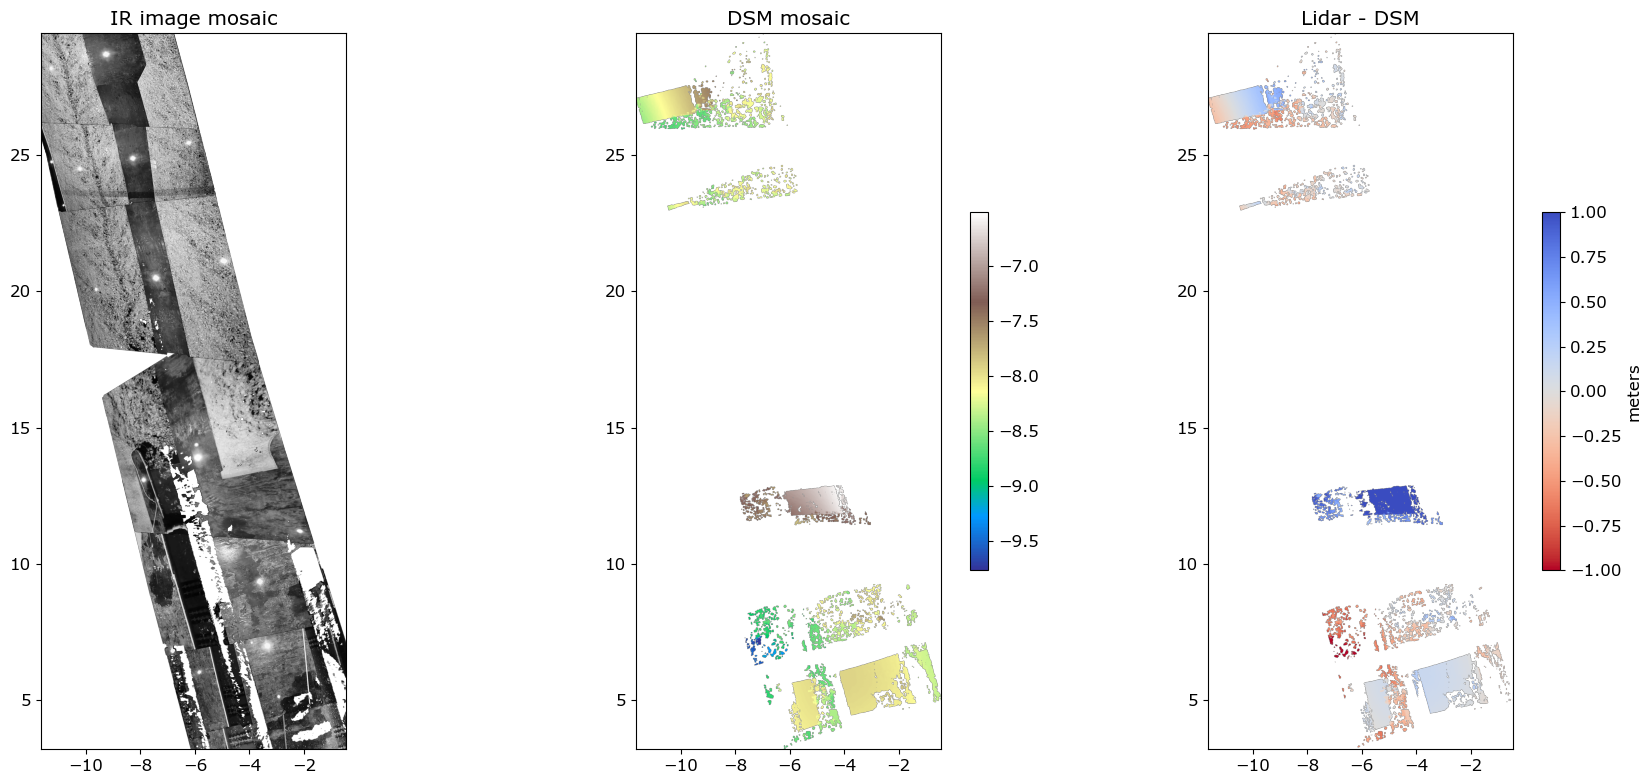

Figure saved to file: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/result.jpg


In [16]:
# Plot the ortho image and DEM mosaics
import matplotlib.pyplot as plt
import xarray as xr

fig_fn = os.path.join(out_folder, 'result.jpg')

# Load the input files
ortho_files = sorted(glob(os.path.join(final_ortho_folder, '*_map.tiff')))

dem_fn = os.path.join(dem_align_folder, 'run-trans_source-DEM.tif')
dem = rxr.open_rasterio(dem_fn).squeeze()
crs = dem.rio.crs
dem = xr.where(dem < -100, np.nan, dem)
dem = dem.rio.write_crs(crs)
refdem = rxr.open_rasterio(ref_dem_fn).squeeze()
refdem = refdem.rio.reproject_match(dem)
refdem = xr.where(refdem < -100, np.nan, refdem)

plt.rcParams.update({'font.sans-serif': 'Verdana', 'font.size': 12})
fig, ax = plt.subplots(1, 3, figsize=(18,8))
# Ortho
for ortho_file in ortho_files:
    ortho = rxr.open_rasterio(ortho_file).squeeze()
    ortho = xr.where(ortho < -1e3, np.nan, ortho)
    ax[0].imshow(
        ortho, 
        cmap='Grays_r',
        extent=(min(ortho.x), max(ortho.x), min(ortho.y), max(ortho.y))
        )
ax[0].set_title('IR image mosaic')
# DEM
im = ax[1].imshow(
    dem, 
    cmap='terrain', 
    extent=(min(dem.x), max(dem.x), min(dem.y), max(dem.y), 'meters')
    )
cb = fig.colorbar(im, shrink=0.5)
ax[1].set_title('DSM mosaic')
# DEM - refdem
im = ax[2].imshow(
    dem - refdem, 
    cmap='coolwarm_r',
    clim=(-1,1),
    extent=(min(dem.x), max(dem.x), min(dem.y), max(dem.y))
    )
cb = fig.colorbar(im, shrink=0.5, label='meters')
ax[2].set_title('Lidar - DSM')

ax[0].set_xlim(ax[1].set_xlim())
ax[0].set_ylim(ax[1].get_ylim())

fig.tight_layout()
plt.show()

fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

In [ ]:
# Try 